In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, MaxPool2D, LeakyReLU

In [2]:
joint_name = ['HeadF', 'HeadB', 'HeadL', 'SpineF', 'SpineM', 'SpineL', 
            'Offset1', 'Offset2', 'HipL', 'HipR', 'ElbowL', 'ArmL', 
            'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 
            'KneeL', 'ShinL', 'ShinR']

joints_idx = [[1, 2], [2, 3], [1, 3], [2, 4], [1, 4], [3, 4], [4, 5], 
            [5, 6], [4, 7], [7, 8], [5, 8], [5, 7], [6, 8], [6, 9], 
            [6, 10], [11, 12], [4, 13], [4, 14], [11, 13], [12, 13], 
            [14, 15], [14, 16], [15, 16], [9, 18], [10, 17], [18, 19], 
            [17, 20]]

In [3]:
# Loading mat file and returning file
def loadMatFile(fileName, key):
    mat = loadmat(fileName)[key]
    print("Loaded:",fileName, key)
    return mat

In [4]:
# Plot 3D points given file and frame number
def plotKnownOrder(matFile, numb):
    mat = matFile[numb]
    x = mat[0]
    y = mat[1]
    z = mat[2]

    # loading plot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # adding points, labels and lines
    try:
        ax.scatter(x,y,z, color='#ff5e5e', s =10, marker='x')
    except:
        pass
    # addLabels(ax, x, y, z)
    drawLines(ax, x, y, z)
    drawAllLines(ax, x, y, z)

    # Labeling plot
    ax.set_title("Rat positioning")
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    plt.show()

# Draw major lines in the rat model
def drawLines(ax,x, y, z):
    # run through all the connections to draw the points
    for i in range(len(joints_idx)):
        try: 
            # Getting both points to draw line
            idx = joints_idx[i]
            x_line = [x[idx[0]-1], x[idx[1]-1]]
            y_line = [y[idx[0]-1], y[idx[1]-1]]
            z_line = [z[idx[0]-1], z[idx[1]-1]]
            z_coord_1 = x[idx[0]-1], y[idx[0]-1], z[idx[0]-1]
            z_coord_2 = x[idx[1]-1], y[idx[1]-1], z[idx[1]-1]

            # Draw lines
            if i < 3: 
                ax.plot(x_line, y_line, z_line, c="#064ea1", linewidth=4)
            elif i < 6:
                ax.plot(x_line, y_line, z_line, c="#64ccd1", linewidth=4)
            else:
                ax.plot(x_line, y_line, z_line, c="#46b8a7", linewidth=4)
        except:
            pass

# Draw all line from every point 
def drawAllLines(ax,x, y, z):
    joint_len = len(joint_name)
    all_lines = []
    for i in range(joint_len):
        for j in range(joint_len):
            if (not([i,j] in all_lines)):
                x_line = [x[i], x[j]]
                y_line = [y[i], y[j]]
                z_line = [z[i], z[j]]
                ax.plot(x_line, y_line, z_line, color='#b1d8fc', linewidth=0.5)
                all_lines.append([i,j])
                all_lines.append([j,i])

In [5]:
# normalizes a matrix
def normalize(matrix):
    max_numb = max(matrix[~np.isnan(matrix)])
    norm = matrix/max_numb
    return np.array(norm)

In [6]:
from scipy.spatial.distance import cdist
# Get the distance to every single point 
def getAllDistances(matFile, numb):
    mat = matFile[numb]
    mat = mat.T
    dist = cdist(mat, mat, 'euclidean')
    return normalize(dist)

In [7]:
# Get the absolute height difference to every single point 
def getAllHeights(matFile, numb):
    mat = matFile[numb]
    z = mat[2]
    height = []

    for i in range(len(joint_name)):
        for j in range(len(joint_name)):
            if np.nan in [z[i], z[j]]:
                height.append(np.nan)
            else:
                height.append(np.abs(z[i]-z[j]))

    # normalizes height data
    height = normalize(np.array(height).reshape(20,20))
    return height


In [8]:
# Get the angle to every single point 
def getAllAngles(matFile, numb):
    mat = matFile[numb]
    mat = mat.T
    angle = cdist(mat, mat, 'cosine')
    return normalize(angle)

In [9]:
def addNans(raw):
    raw_copy = np.array(raw.copy())

    for i in range(raw_copy.shape[0]):
        rand_numb = np.random.randint(0, 4)
        rand_index = random.sample(range(3, 20), rand_numb)
        for j in range(rand_numb):
            raw_copy[i][:,rand_index[j]] = np.nan
    return raw_copy


In [10]:
def getData(data, numb): 
    cnn_inputs = []
    for i in range(numb):
        dist = getAllDistances(data, i) 
        height = getAllHeights(data, i)
        angle = getAllAngles(data, i)
        for j in range(0, len(joint_name)):
            temp = np.array([dist[j], height[j], angle[j]])
            first = temp[:,0:3]
            second = temp[:,3:20]
            first = first [ :, first[0].argsort()]
            second = second [ :, second[0].argsort()]
            output = np.concatenate((first, second), axis =1)
            cnn_inputs.append(output)

    # DIMENTION CHANGE
    # cnn_inputs = np.array(cnn_inputs)[:,:,:13]
    cnn_inputs = np.array(cnn_inputs)[:,:,:20]
    # cnn_inputs = np.array(cnn_inputs).reshape((numb*20, 39))
    cnn_inputs = np.array(cnn_inputs).reshape((numb*20, 60))
    where_are_NaNs = np.isnan(cnn_inputs)
    cnn_inputs[where_are_NaNs] = 0
    return cnn_inputs


In [11]:
# Creates the ML training platform to predict rat joints
def ml_traning(train_data, train_labels, test_data, test_labels):
    # DIMENTION CHANGE
    # train_data = train_data.reshape(train_data.shape[0], 39)
    # test_data = test_data.reshape(test_data.shape[0], 39)
    train_data = train_data.reshape(train_data.shape[0], 60)
    test_data = test_data.reshape(test_data.shape[0], 60)
    train_data = train_data.astype('float32')
    test_data = test_data.astype('float32')

    model = createModel()
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(x=train_data,y=train_labels, verbose='auto', batch_size=20, epochs=10)
    
    output = model.evaluate(test_data, test_labels)
    print("Loss:", output[0])
    print("Accuracy:", output[1]*100)
    return model

# Creates the model for the CNN
def createModel():
    model = Sequential()
    # model.add(Dense(320, activation= LeakyReLU()))
    # model.add(Dense(320, activation= LeakyReLU()))
    # model.add(Dense(80, activation= LeakyReLU()))
    model.add(Dense(40, activation= LeakyReLU()))
    # model.add(Dropout(rate=0.25))
    model.add(Dense(len(joint_name), activation = "softmax"))
    return model

In [12]:
train_numb = 500
test_numb = 500
mat_file = loadmat('markerSplit_1_shuffled.mat')

In [26]:
data = mat_file['alteredM']
labels = mat_file['labelsM']

# mat_len = int(len(labels))
# mat_half = int(mat_len/2)
mat_len = 2000
mat_half = 1000

pre_train_data = addNans(data[0:mat_half])
pre_test_data = addNans(data[(mat_half):mat_len])
pre_train_labels = labels[0:mat_half]
pre_test_labels = labels[(mat_half):mat_len]

print(pre_train_data.shape)
print(pre_test_data.shape)
print(pre_train_labels.shape)
print(pre_test_labels.shape)

(1000, 3, 20)
(1000, 3, 20)
(1000, 20)
(1000, 20)


In [27]:
train_data = getData(pre_train_data, train_numb)
test_data = getData(pre_test_data, test_numb)
train_labels = pre_train_labels.flatten()[0:(train_numb*20)]-1
test_labels = pre_test_labels.flatten()[0:(test_numb*20)]-1
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(10000, 60)
(10000, 60)
(10000,)
(10000,)


In [28]:
nans_train = np.sort(np.where(~train_data.any(axis=1))[0])[::-1]
nans_test = np.sort(np.where(~test_data.any(axis=1))[0])[::-1]

train_data_new = list(train_data)
test_data_new = list(test_data)
train_labels_new = list(train_labels)
test_labels_new = list(test_labels)

for i in nans_train:
    train_data_new.pop(i)
    train_labels_new.pop(i)
for i in nans_test:
    test_data_new.pop(i)
    test_labels_new.pop(i)

train_data_new = np.array(train_data_new)
train_labels_new = np.array(train_labels_new)
test_data_new = np.array(test_data_new)
test_labels_new = np.array(test_labels_new)

print(train_data_new.shape)
print(train_labels_new.shape)
print(test_data_new.shape)
print(test_labels_new.shape)


(8425, 60)
(8425,)
(8408, 60)
(8408,)


In [29]:
skeleton_model = ml_traning(train_data_new, train_labels_new, test_data_new, test_labels_new)

Epoch 1/10
422/422 [==============================] - 2s 3ms/step - loss: 2.0762 - accuracy: 0.4845
Epoch 2/10
422/422 [==============================] - 1s 3ms/step - loss: 0.7865 - accuracy: 0.9366
Epoch 3/10
422/422 [==============================] - 1s 3ms/step - loss: 0.3407 - accuracy: 0.9821
Epoch 4/10
422/422 [==============================] - 1s 3ms/step - loss: 0.1841 - accuracy: 0.9901
Epoch 5/10
422/422 [==============================] - 1s 3ms/step - loss: 0.1140 - accuracy: 0.9925
Epoch 6/10
422/422 [==============================] - 1s 2ms/step - loss: 0.0769 - accuracy: 0.9954
Epoch 7/10
422/422 [==============================] - 1s 3ms/step - loss: 0.0547 - accuracy: 0.9972
Epoch 8/10
422/422 [==============================] - 2s 4ms/step - loss: 0.0404 - accuracy: 0.9977
Epoch 9/10
422/422 [==============================] - 1s 3ms/step - loss: 0.0306 - accuracy: 0.9987
Epoch 10/10
263/263 [==============================] - 1s 3ms/step - loss: 0.0246 - accuracy: 0.9968

In [30]:
# Tests individual points and tells you if the CNN worked
def handTest(image_index, test_data, label, model, maxNumb):
    max_index = len(joint_name)*maxNumb-1
    if image_index <= max_index:
        predict(test_data, image_index, label, model)
    else:
        print("ERROR: Your predict_index must be below", max_index)

# Showing individual predictions
def predict(data, image_index, label, model):
    img = [data[image_index]]
    # DIMENTION CHANGE
    # img = np.array(img).reshape(3,13)
    img = np.array(img).reshape(3,20)
    plt.imshow(img)
    plt.show()

    # pred = model.predict(img.reshape(1, 39))
    pred = model.predict(img.reshape(1, 60))
    predict = pred.argmax()
    actual = label[image_index]

    print("Actual:", actual)
    print("Predicted:", predict)
    
    if predict == actual:
        print("YAY ✿(ᵔ‿ᵔ)")
    else:
        print("Wrong (◕︵◕)")

    

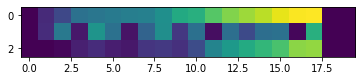

Actual: 0
Predicted: 0
YAY ✿(ᵔ‿ᵔ)


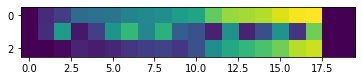

Actual: 1
Predicted: 1
YAY ✿(ᵔ‿ᵔ)


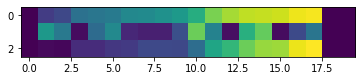

Actual: 2
Predicted: 2
YAY ✿(ᵔ‿ᵔ)


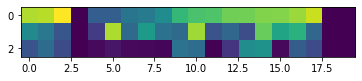

Actual: 6
Predicted: 6
YAY ✿(ᵔ‿ᵔ)


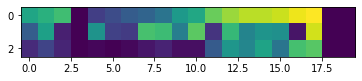

Actual: 3
Predicted: 3
YAY ✿(ᵔ‿ᵔ)


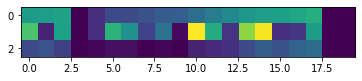

Actual: 10
Predicted: 10
YAY ✿(ᵔ‿ᵔ)


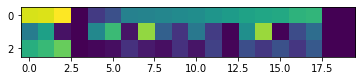

Actual: 19
Predicted: 19
YAY ✿(ᵔ‿ᵔ)


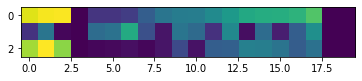

Actual: 8
Predicted: 8
YAY ✿(ᵔ‿ᵔ)


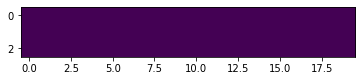

Actual: 12
Predicted: 3
Wrong (◕︵◕)


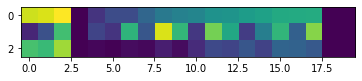

Actual: 9
Predicted: 9
YAY ✿(ᵔ‿ᵔ)


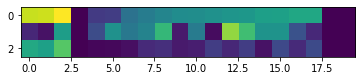

Actual: 16
Predicted: 16
YAY ✿(ᵔ‿ᵔ)


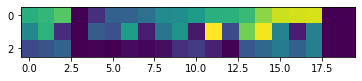

Actual: 14
Predicted: 14
YAY ✿(ᵔ‿ᵔ)


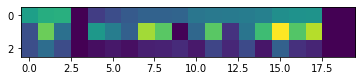

Actual: 4
Predicted: 4
YAY ✿(ᵔ‿ᵔ)


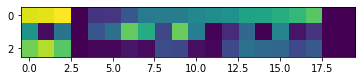

Actual: 17
Predicted: 17
YAY ✿(ᵔ‿ᵔ)


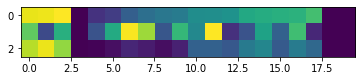

Actual: 18
Predicted: 18
YAY ✿(ᵔ‿ᵔ)


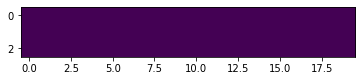

Actual: 7
Predicted: 3
Wrong (◕︵◕)


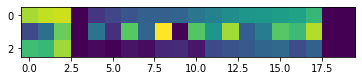

Actual: 5
Predicted: 5
YAY ✿(ᵔ‿ᵔ)


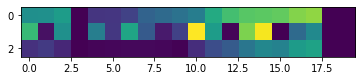

Actual: 11
Predicted: 11
YAY ✿(ᵔ‿ᵔ)


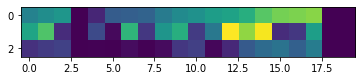

Actual: 15
Predicted: 15
YAY ✿(ᵔ‿ᵔ)


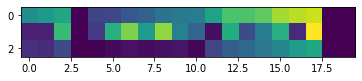

Actual: 13
Predicted: 13
YAY ✿(ᵔ‿ᵔ)


In [35]:
for i in range(420,440):
    handTest(i, test_data, test_labels, skeleton_model, test_numb)

Train input


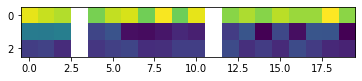

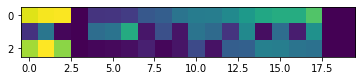

Test input


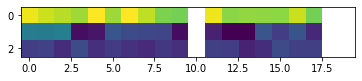

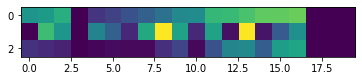

In [32]:
index = 1234
frame = int(index/20)

print("Train input")
plt.imshow(pre_train_data[frame].reshape(3,20))
plt.show()
# DIMENTION CHANGE
# plt.imshow(train_data[index].reshape(3,13))
plt.imshow(train_data[index].reshape(3,20))
plt.show()

print("Test input")
plt.imshow(pre_test_data[frame].reshape(3,20))
plt.show()
# plt.imshow(test_data[index].reshape(3,13))
plt.imshow(test_data[index].reshape(3,20))
plt.show()